# 7 File IO and Parallel Analysis
## 7.1 Storing ROOT Objects

ROOT offers the possibility to write instances of classes on disk, into a ROOT-file (see the [```TFile```](https://root.cern.ch/doc/master/classTFile.html) class for more details). One says that the object is made “persistent” by storing it on disk. When reading the file back, the object is reconstructed in memory. The requirement to be satisfied to perform I/O of instances of a certain class is that the ROOT type system is aware of the layout in memory of that class. This topic is beyond the scope of this document: it is worth to mention that I/O can be performed out of the box for the almost complete set of ROOT classes.

We can explore this functionality with histograms and two simple macros.

In [1]:
// Instance of our histogram
TH1F histogram_7_1("stored_histogram","My Title;X;# of entries",100,-5,5);

// Let's fill it randomly
histogram_7_1.FillRandom("gaus");

// Let's open a TFile
TFile out_file("../data/my_rootfile.root","RECREATE");

// Write the histogram in the file
histogram_7_1.Write();
// Close the file
out_file.Close();

Not bad, eh ? Especially for a language that does not foresees persistency natively like C++. The RECREATE option forces ROOT to create a new file even if a file with the same name exists on disk.

Now, you may use the Cling command line to access information in the file and draw the previously written histogram:

```
>  root my_rootfile.root
root [0]
Attaching file my_rootfile.root as _file0...
root [1] _file0->ls()
TFile**     my_rootfile.root
 TFile*     my_rootfile.root
  KEY: TH1F my_histogram;1 My Title
root [2] my_histogram->Draw()
```
Alternatively, you can use a simple macro to carry out the job:



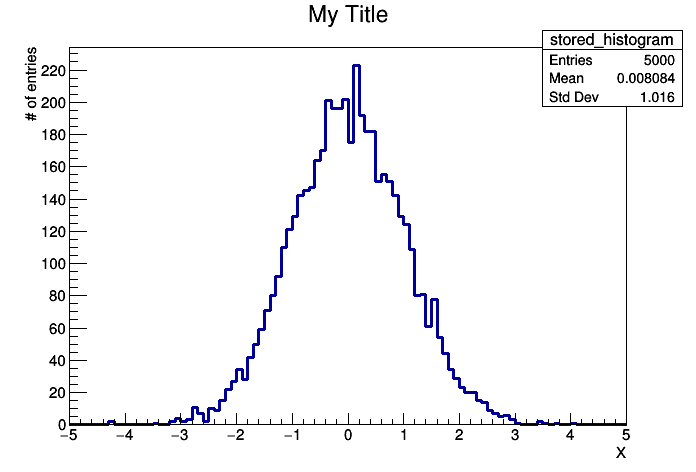

In [2]:
// %jsroot debug
auto canvas_7_1=new TCanvas("canvas_7_1","canvas_7_1");
// Let's open the TFile
TFile in_file("../data/my_rootfile.root");

// Get the Histogram out
TH1F* histogram_7_1_2;
in_file.GetObject("stored_histogram",histogram_7_1_2);

// Draw it
histogram_7_1_2->Draw();
canvas_7_1->Draw();

## 7.2 N-tuples in ROOT

### 7.2.1 Storing simple N-tuples

Up to now we have seen how to manipulate input read from ASCII files. ROOT offers the possibility to do much better than that, with its own n-tuple classes. Among the many advantages provided by these classes one could cite

* Optimised disk I/O.

* Possibility to store many n-tuple rows.

* Write the n-tuples in ROOT files.

* Interactive inspection with [```TBrowser```](https://root.cern.ch/doc/master/classTBrowser.html).

* Store not only numbers, but also objects in the columns.

In this section we will discuss briefly the [```TNtuple```](https://root.cern.ch/doc/v606/classTNtuple.html) class, which is a simplified version of the [```TTree```](https://root.cern.ch/doc/v606/classTTree.html) class. A ROOT [```TNtuple```](https://root.cern.ch/doc/v606/classTNtuple.html) object can store rows of float entries. Let’s tackle the problem according to the usual strategy commenting a minimal example

In [3]:
// Fill an n-tuple and write it to a file simulating measurement of
// conductivity of a material in different conditions of pressure
// and temperature.

    TFile ofile("../data/conductivity_experiment.root","RECREATE");

    // Initialise the TNtuple
    TNtuple cond_data("cond_data",
                      "Example N-Tuple",
                      "Potential:Current:Temperature:Pressure");

    // Fill it randomly to fake the acquired data
    TRandom3 rndm;
    float pot,cur,temp,pres;
    for (int i=0;i<10000;++i){
        pot=rndm.Uniform(0.,10.);      // get voltage
        temp=rndm.Uniform(250.,350.);  // get temperature
        pres=rndm.Uniform(0.5,1.5);    // get pressure
        cur=pot/(10.+0.05*(temp-300.)-0.2*(pres-1.)); // current
// add some random smearing (measurement errors)
        pot*=rndm.Gaus(1.,0.01); // 1% error on voltage
        temp+=rndm.Gaus(0.,0.3); // 0.3 abs. error on temp.
        pres*=rndm.Gaus(1.,0.02);// 1% error on pressure
        cur*=rndm.Gaus(1.,0.01); // 1% error on current
// write to ntuple
        cond_data.Fill(pot,cur,temp,pres);
        }

    // Save the ntuple and close the file
    cond_data.Write();
//     ofile.Close();

This data written to this example n-tuple represents, in the statistical sense, three independent variables (Potential or Voltage, Pressure and Temperature), and one variable (Current) which depends on the others according to very simple laws, and an additional Gaussian smearing. This set of variables mimics a measurement of an electrical resistance while varying pressure and temperature.

Imagine your task now consists in finding the relations among the variables – of course without knowing the code used to generate them. You will see that the possibilities of the [```NTuple```](https://root.cern.ch/doc/v606/classTNtuple.html) class enable you to perform this analysis task. Open the ROOT file (```cond_data.root```) written by the macro above in an interactive session and use a [```TBrowser```](https://root.cern.ch/doc/master/classTBrowser.html) to interactively inspect it:

```
root[0] TBrowser b
```

You find the columns of your n-tuple written as leafs. Simply clicking on them you can obtain histograms of the variables!

Next, try the following commands at the shell prompt and in the interactive ROOT shell, respectively:
```
> root conductivity_experiment.root
Attaching file conductivity_experiment.root as _file0...
root [0] cond_data->Draw("Current:Potential")
```

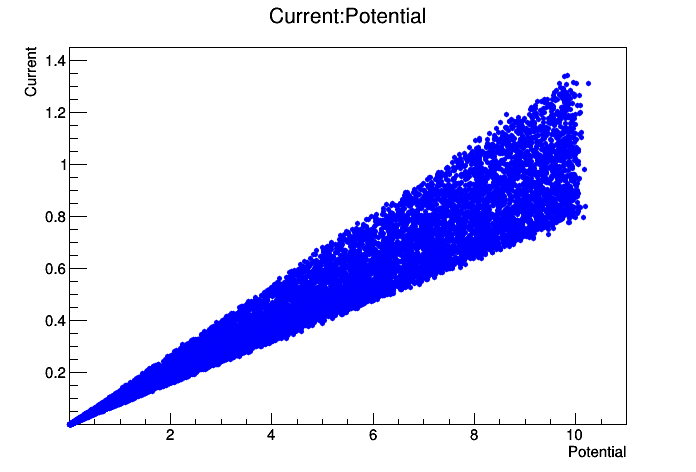

In [4]:
cond_data.Draw("Current:Potential");
canvas_7_1->Draw();

You just produced a correlation plot with one single line of code!

Try to extend the syntax typing for example

```
root [1] cond_data->Draw("Current:Potential","Temperature<270")
```

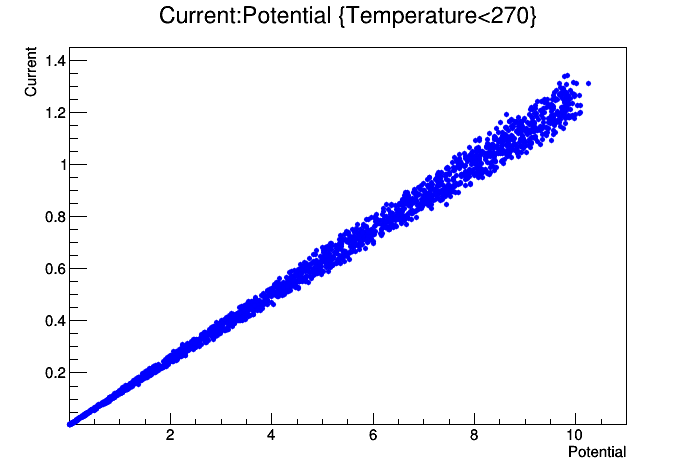

In [5]:
cond_data.Draw("Current:Potential","Temperature<270");
canvas_7_1->Draw();

What do you obtain ?

Now try
```
root [2] cond_data->Draw("Current/Potential:Temperature")
```

You will see this result:

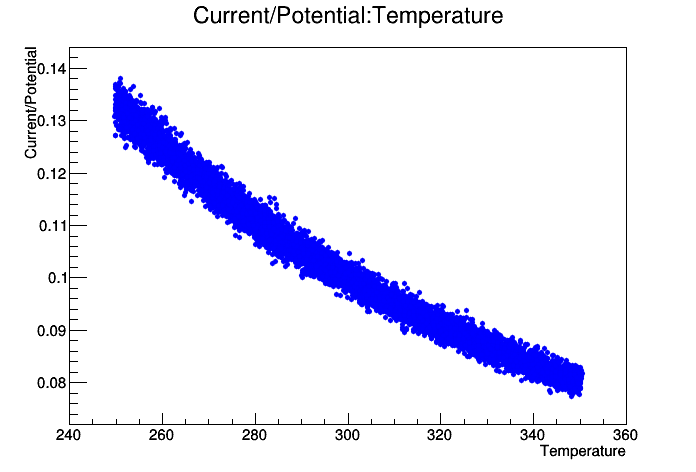

In [6]:
cond_data.Draw("Current/Potential:Temperature");
canvas_7_1->Draw();

It should have become clear from these examples how to navigate in such a multi-dimensional space of variables and unveil relations between variables using n-tuples.

### 7.2.2 Reading N-tuples

For completeness, you find here a small macro to read the data back from a ROOT n-tuple

In [7]:
%%cpp -d
// Read the previously produced N-Tuple and print on screen
// its content

void read_ntuple_from_file(){

    // Open a file, save the ntuple and close the file
    TFile in_file("../data/conductivity_experiment.root");
    TNtuple* my_tuple;in_file.GetObject("cond_data",my_tuple);
    float pot,cur,temp,pres; float* row_content;

    cout << "Potential\tCurrent\tTemperature\tPressure\n";
    for (int irow=0;irow<my_tuple->GetEntries();++irow){
        my_tuple->GetEntry(irow);
        row_content = my_tuple->GetArgs();
        pot = row_content[0];
        cur = row_content[1];
        temp = row_content[2];
        pres = row_content[3];
        cout << pot << "\t" << cur << "\t" << temp
             << "\t" << pres << endl;
        }

    }

The macro shows the easiest way of accessing the content of a n-tuple: after loading the n-tuple, its branches are assigned to variables and [```GetEntry(long)```](https://root.cern.ch/doc/master/classTTree.html#a9fc48df5560fce1a2d63ecd1ac5b40cb) automatically fills them with the content for a specific row. By doing so, the logic for reading the n-tuple and the code to process it can be split and the source code remains clear.

### 7.2.3 Storing Arbitrary N-tuples

It is also possible to write n-tuples of arbitrary type by using ROOT’s ```TBranch``` class. This is especially important as [```TNtuple::Fill()```](https://root.cern.ch/doc/v606/classTNtuple.html) accepts only floats. The following macro creates the same n-tuple as before but the branches are booked directly. The [```Fill()```](https://root.cern.ch/doc/master/classTH1.html) function then fills the current values of the connected variables to the tree.

In [8]:
%%cpp -d
    
// Fill an n-tuple and write it to a file simulating measurement of
// conductivity of a material in different conditions of pressure
// and temperature using branches.

void write_ntuple_to_file_advanced(
   const std::string& outputFileName="../data/conductivity_experiment.root"
   ,unsigned int numDataPoints=1000000){

   TFile ofile(outputFileName.c_str(),"RECREATE");

   // Initialise the TNtuple
   TTree cond_data("cond_data", "Example N-Tuple");

   // define the variables and book them for the ntuple
   float pot,cur,temp,pres;
   cond_data.Branch("Potential", &pot, "Potential/F");
   cond_data.Branch("Current", &cur, "Current/F");
   cond_data.Branch("Temperature", &temp, "Temperature/F");
   cond_data.Branch("Pressure", &pres, "Pressure/F");

   for (int i=0;i<numDataPoints;++i){
      // Fill it randomly to fake the acquired data
      pot=gRandom->Uniform(0.,10.)*gRandom->Gaus(1.,0.01);
      temp=gRandom->Uniform(250.,350.)+gRandom->Gaus(0.,0.3);
      pres=gRandom->Uniform(0.5,1.5)*gRandom->Gaus(1.,0.02);
      cur=pot/(10.+0.05*(temp-300.)-0.2*(pres-1.))*
                    gRandom->Gaus(1.,0.01);
      // write to ntuple
      cond_data.Fill();}

   // Save the ntuple and close the file
   cond_data.Write();
   ofile.Close();
}

The [```Branch()```](https://root.cern.ch/doc/master/classTBranch.html) function requires a pointer to a variable and a definition of the variable type. The following table lists some of the possible values. Please note that ROOT is not checking the input and mistakes are likely to result in serious problems. This holds especially if values are read as another type than they have been written, e.g. when storing a variable as float and reading it as double.

List of variable types that can be used to define the type of a branch in ROOT:

|type|size|C++|identifier|
|---|---|---|---|
|signed integer|32 bit|int|I|
|   |64 bit|long|L|
|unsigned integer|32 bit|unsigned int|i|
|   |64 bit|unsigned long|l|
|floating point|32 bit|float|F|
|   |64 bit|double|D|
|boolean|-|bool|O|

### 7.2.4 Processing N-tuples Spanning over Several Files

Usually n-tuples or trees span over many files and it would be difficult to add them manually. ROOT thus kindly provides a helper class in the form of [```TChain```](https://root.cern.ch/doc/master/classTChain.html). Its usage is shown in the following macro which is very similar to the previous example. The constructor of a [```TChain```](https://root.cern.ch/doc/master/classTChain.html) takes the name of the [```TTree```](https://root.cern.ch/doc/v606/classTTree.html) (or [```TNuple```]((https://root.cern.ch/doc/v606/classTNtuple.html))) as an argument. The files are added with the function [```Add(fileName)```](https://root.cern.ch/doc/master/classTH1.html), where one can also use wild-cards as shown in the example.

In [9]:
%%cpp -d
// Read several previously produced N-Tuples and print on screen its
// content.
//
// you can easily create some files with the following statement:
//
// for i in 0 1 2 3 4 5; \\
// do root -l -x -b -q \\
// "write_ntuple_to_file.cxx \\
// (\"conductivity_experiment_${i}.root\", 100)"; \\
//  done

void read_ntuple_with_chain(){
   // initiate a TChain with the name of the TTree to be processed
   TChain in_chain("cond_data");
   in_chain.Add("../data/conductivity_experiment*.root"); // add files,
                                                  // wildcards work

   // define variables and assign them to the corresponding branches
   float pot, cur, temp, pres;
   in_chain.SetBranchAddress("Potential", &pot);
   in_chain.SetBranchAddress("Current", &cur);
   in_chain.SetBranchAddress("Temperature", &temp);
   in_chain.SetBranchAddress("Pressure", &pres);

   cout << "Potential\tCurrent\tTemperature\tPressure\n";
   for (size_t irow=0; irow<in_chain.GetEntries(); ++irow){
      in_chain.GetEntry(irow); // loads all variables that have
                                    // been connected to branches
      cout << pot << "\t" << cur << "\t" << temp <<
                          "\t" << pres << endl;
   }
}

### 7.2.5 For the advanced user: Processing trees with a selector script

Another very general and powerful way of processing a ```TChain``` is provided via the method ```TChain::Process()```. This method takes as arguments an instance of a – user-implemented– class of type ```TSelector```, and – optionally – the number of entries and the first entry to be processed. A template for the class ```TSelector``` is provided by the method ```TTree::MakeSelector```, as is shown in the little macro makeSelector.C below.

It opens the n-tuple ```conductivity_experiment.root``` from the example above and creates from it the header file ```MySelector.h``` and a template to insert your own analysis code, ```MySelector.C```.

```
{
// create template class for Selector to run on a tree
//////////////////////////////////////////////////////
//
// open root file containing the Tree
    TFile f("conductivity_experiment.root");
// create TTree object from it
    TTree *t; f.GetObject("cond_data",t);
// this generates the files MySelector.h and MySelector.C
    t->MakeSelector("MySelector");
}
```


The template contains the entry points ```Begin()``` and ```SlaveBegin()``` called before processing of the TChain starts, Process() called for every entry of the chain, and ```SlaveTerminate()``` and ```Terminate()``` called after the last entry has been processed. Typically, initialization like booking of histograms is performed in ```SlaveBegin()```, the analysis, i.e. the selection of entries, calculations and filling of histograms, is done in ```Process()```, and final operations like plotting and storing of results happen in ```SlaveTerminate()``` or ```Terminate()```.

The entry points ```SlaveBegin()``` and ```SlaveTerminate()``` are called on so-called slave nodes only if parallel processing via PROOF or PROOF lite is enabled, as will be explained below.

A simple example of a selector class is shown in the macro MySelector.C. The example is executed with the following sequence of commands:

```
> TChain *ch=new TChain("cond_data", "Chain for Example N-Tuple");
> ch->Add("conductivity_experiment*.root");
> ch->Process("MySelector.C+");
```

As usual, the “+” appended to the name of the macro to be executed initiates the compilation of the ```MySelector.C``` with the system compiler in order to improve performance.

The code in ```MySelector.C```, shown in the listing below, books some histograms in ```SlaveBegin()``` and adds them to the instance fOutput, which is of the class TList.4 The final processing in ```Terminate()``` allows to access histograms and store, display or save them as pictures. This is shown in the example via the TList fOutput. See the commented listing below for more details; most of the text is actually comments generated automatically by ```TTree::MakeSelector```.


    #define MySelector_cxx
    // The class definition in MySelector.h has been generated automatically
    // by the ROOT utility TTree::MakeSelector(). This class is derived
    // from the ROOT class TSelector. For more information on the TSelector
    // framework see $ROOTSYS/README/README.SELECTOR or the ROOT User Manual.

    // The following methods are defined in this file:
    //    Begin():        called every time a loop on the tree starts,
    //                    a convenient place to create your histograms.
    //    SlaveBegin():   called after Begin(), when on PROOF called only on the
    //                    slave servers.
    //    Process():      called for each event, in this function you decide what
    //                    to read and fill your histograms.
    //    SlaveTerminate: called at the end of the loop on the tree, when on PROOF
    //                    called only on the slave servers.
    //    Terminate():    called at the end of the loop on the tree,
    //                    a convenient place to draw/fit your histograms.
    //
    // To use this file, try the following session on your Tree T:
    //
    // root> T->Process("MySelector.C")
    // root> T->Process("MySelector.C","some options")
    // root> T->Process("MySelector.C+")
    //

    #include "MySelector.h"
    #include <TH2.h>
    #include <TStyle.h>


    void MySelector::Begin(TTree * /*tree*/)
    {
       // The Begin() function is called at the start of the query.
       // When running with PROOF Begin() is only called on the client.
       // The tree argument is deprecated (on PROOF 0 is passed).

       TString option = GetOption();

    }

    void MySelector::SlaveBegin(TTree * /*tree*/)
    {
       // The SlaveBegin() function is called after the Begin() function.
       // When running with PROOF SlaveBegin() is called on each slave server.
       // The tree argument is deprecated (on PROOF 0 is passed).

       TString option = GetOption();

    }

    Bool_t MySelector::Process(Long64_t entry)
    {
       // The Process() function is called for each entry in the tree (or possibly
       // keyed object in the case of PROOF) to be processed. The entry argument
       // specifies which entry in the currently loaded tree is to be processed.
       // It can be passed to either MySelector::GetEntry() or TBranch::GetEntry()
       // to read either all or the required parts of the data. When processing
       // keyed objects with PROOF, the object is already loaded and is available
       // via the fObject pointer.
       //
       // This function should contain the "body" of the analysis. It can contain
       // simple or elaborate selection criteria, run algorithms on the data
       // of the event and typically fill histograms.
       //
       // The processing can be stopped by calling Abort().
       //
       // Use fStatus to set the return value of TTree::Process().
       //
       // The return value is currently not used.

       return kTRUE;
    }

    void MySelector::SlaveTerminate()
    {
       // The SlaveTerminate() function is called after all entries or objects
       // have been processed. When running with PROOF SlaveTerminate() is called
       // on each slave server.

    }

    void MySelector::Terminate()
    {
       // The Terminate() function is the last function to be called during
       // a query. It always runs on the client, it can be used to present
       // the results graphically or save the results to file.

    }

### 7.2.6 For power-users: Multi-core processing with PROOF lite

The processing of n-tuples via a selector function of type ```TSelector``` through ```TChain::Process()```, as described at the end of the previous section, offers an additional advantage in particular for very large data sets: on distributed systems or multi-core architectures, portions of data can be processed in parallel, thus significantly reducing the execution time. On modern computers with multi-core CPUs or hardware-threading enabled, this allows a much faster turnaround of analyses, since all the available CPU power is used.

On distributed systems, a PROOF server and worker nodes have to be set up, as described in detail in the ROOT documentation. On a single computer with multiple cores, ```PROOF``` lite can be used instead. Try the following little macro, RunMySelector.C, which contains two extra lines compared to the example above (adjust the number of workers according to the number of CPU cores):

    {// set up a TChain
    TChain *ch=new TChain("cond_data", "My Chain for Example N-Tuple");
     ch->Add("conductivity_experiment*.root");
    // eventually, start Proof Lite on cores
    TProof::Open("workers=4");
    ch->SetProof();
    ch->Process("MySelector.C+");}

The first command, ```TProof::Open(const char*)``` starts a local PROOF server (if no arguments are specified, all cores will be used), and the command ```ch->SetProof();``` enables processing of the chain using PROOF. Now, when issuing the command ```ch->Process("MySelector.C+);```, the code in ```MySelector.C``` is compiled and executed on each slave node. The methods ```Begin()``` and ```Terminate()``` are executed on the master only. The list of n-tuple files is analysed, and portions of the data are assigned to the available slave processes. Histograms booked in SlaveBegin() exist in the processes on the slave nodes, and are filled accordingly. Upon termination, the PROOF master collects the histograms from the slaves and merges them. In ```Terminate()``` all merged histograms are available and can be inspected, analysed or stored. The histograms are handled via the instances fOutput of class TList in each slave process, and can be retrieved from this list after merging in Terminate.

To explore the power of this mechanism, generate some very large n-tuples using the script from the section Storing Arbitrary N-tuples - you could try 10 000 000 events (this results in a large n-tuple of about 160 MByte in size). You could also generate a large number of files and use wildcards to add the to the TChain. Now execute: ```> root -l RunMySelector.C``` and watch what happens:

    Processing RunMySelector.C...
     +++ Starting PROOF-Lite with 4 workers +++
    Opening connections to workers: OK (4 workers)
    Setting up worker servers: OK (4 workers)
    PROOF set to parallel mode (4 workers)

    Info in <TProofLite::SetQueryRunning>: starting query: 1
    Info in <TProofQueryResult::SetRunning>: nwrks: 4
    Info in <TUnixSystem::ACLiC>: creating shared library
                                 ~/DivingROOT/macros/MySelector_C.so
    *==* ----- Begin of Job ----- Date/Time = Wed Feb 15 23:00:04 2012
    Looking up for exact location of files: OK (4 files)
    Looking up for exact location of files: OK (4 files)
    Info in <TPacketizerAdaptive::TPacketizerAdaptive>:
                          Setting max number of workers per node to 4
    Validating files: OK (4 files)
    Info in <TPacketizerAdaptive::InitStats>:
                          fraction of remote files 1.000000
    Info in <TCanvas::Print>:
           file ResistanceDistribution.png has been created
    *==* ----- End of Job ----- Date/Time = Wed Feb 15 23:00:08 2012
    Lite-0: all output objects have been merged


Log files of the whole processing chain are kept in the directory ```~.proof``` for each worker node. This is very helpful for debugging or if something goes wrong. As the method described here also works without using PROOF, the development work on an analysis script can be done in the standard way on a small subset of the data, and only for the full processing one would use parallelism via PROOF.

It is worth to remind the reader that the speed of typical data analysis programs limited by the I/O speed (for example the latencies implied by reading data from a hard drive). It is therefore expected that this limitation cannot be eliminated with the usage of any parallel analysis toolkit.

## 7.2.7 Optimisation Regarding N-tuples

ROOT automatically applies compression algorithms on n-tuples to reduce the memory consumption. A value that is in most cases the same will consume only small space on your disk (but it has to be decompressed on reading). Nevertheless, you should think about the design of your n-tuples and your analyses as soon as the processing time exceeds some minutes.

* Try to keep your n-tuples simple and use appropriate variable types. If your measurement has only a limited precision, it is needless to store it with double precision.

* Experimental conditions that do not change with every single measurement should be stored in a separate tree. Although the compression can handle redundant values, the processing time increase with every variable that has to be filled.

* The function SetCacheSize(long) specifies the size of the cache for reading a TTree object from a file. The default value is 30MB. A manual increase may help in certain situations. Please note that the caching mechanism can cover only one TTree object per TFile object.

* You can select the branches to be covered by the caching algorithm with AddBranchToCache and deactivate unneeded branches with SetBranchStatus. This mechanism can result in a significant speed-up for simple operations on trees with many branches.

* You can measure the performance easily with TTreePerfStats. The ROOT documentation on this class also includes an introductory example. For example, TTreePerfStats can show you that it is beneficial to store meta data and payload data separately, i.e. write the meta data tree in a bulk to a file at the end of your job instead of writing both trees interleaved.